# Assignment 01 | Where are we with pandas and matplotlib

Erick Cohen

2025 Jan 21


In [1]:
import pandas as pd
import numpy as np
import math
from datetime import date, datetime
import matplotlib.pyplot as plt
from typing import Tuple

# constants
PATH_TO_COVID_DATA = "data/covid19cases_test.csv"

# read in covid data
covid_data = pd.read_csv(PATH_TO_COVID_DATA)

In [2]:
def create_date_offset(
        data: pd.DataFrame = covid_data,
        date_to_subtract: datetime.date = datetime.strptime(
            "2020-02-01", "%Y-%m-%d")
) -> pd.Series:
    """
    Takes in covid_data df and returns date offset column. If column has 
    missing values, the values will be filled with math.nan, else the days
    offset.
    """

    date_col = [
        math.nan if d is np.nan else (datetime.strptime(
            d, "%Y-%m-%d") - date_to_subtract).days for d in data["date"]
    ]

    return date_col


covid_data["date_offset"] = create_date_offset()

In [3]:
def create_normalized_cases(data: pd.DataFrame = covid_data) -> pd.Series:
    """
    Create normalized cases column
    """

    return data["cases"] / data["population"]


covid_data["normalized_cases"] = create_normalized_cases()

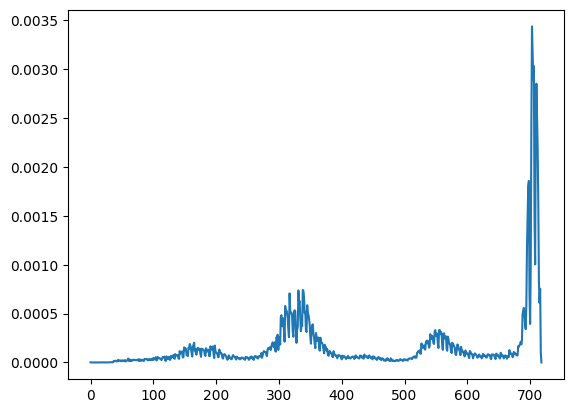

In [4]:
example_county = covid_data.loc[
    covid_data["area"] == "Alameda"
]
plt.plot(example_county["date_offset"], example_county["normalized_cases"])

In [5]:
def get_statistical_summaries(data: pd.DataFrame = covid_data) -> pd.DataFrame:
    """
    Function to get median and IQR
    """
    # Grab only numerical columns (dropping columns by name as described in presentation)
    data_safe_cols = data.drop(columns=["date", "area", "area_type"])

    # Return dataframe with 25th, 50th, and 75th quantiles grouped by date offset column
    return data_safe_cols.groupby(["date_offset"]).agg(
        norm_counts_median=pd.NamedAgg(
            column="normalized_cases", aggfunc="median"),
        q_25=pd.NamedAgg(column="normalized_cases",
                         aggfunc=lambda x: x.quantile(0.25)),
        q_75=pd.NamedAgg(column="normalized_cases",
                         aggfunc=lambda x: x.quantile(0.75)),
    ).reset_index()


stat_summaries_df = get_statistical_summaries()

In [6]:
def get_running_average(stat_sum_data: pd.DataFrame = stat_summaries_df, days_window: int = 7) -> pd.DataFrame:
    """
    Gets n day rolling window
    """
    return stat_sum_data.rolling(window=days_window).mean()


rolling_mean_df = get_running_average()

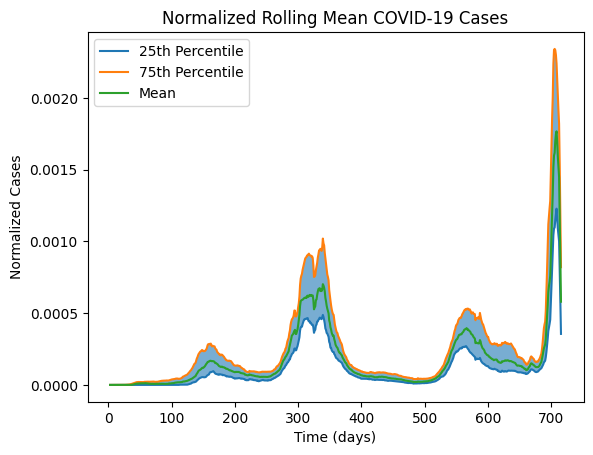

In [7]:
def make_final_plot(rolling_mean_data: pd.DataFrame = rolling_mean_df) -> None:
    """
    Produces final plot using matplotlib
    """
    plt.plot("date_offset", "q_25", data=rolling_mean_data,
             label="25th Percentile")
    plt.plot("date_offset", "q_75", data=rolling_mean_data,
             label="75th Percentile")
    plt.fill_between("date_offset", "q_25", "q_75",
                     data=rolling_mean_data, alpha=0.6)
    plt.plot("date_offset", "norm_counts_median",
             data=rolling_mean_data, label="Mean")

    plt.title("Normalized Rolling Mean COVID-19 Cases")
    plt.xlabel("Time (days)")
    plt.ylabel("Normalized Cases")

    plt.legend()

    plt.show()


make_final_plot()